In [326]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, log_loss
import operator
import json
from IPython import display
import os
import warnings

import random

np.random.seed(0)
warnings.filterwarnings("ignore")
THRESHOLD = 4

Task: To predict whether the user likes the mobile phone or not. <br>
Assumption: If the average rating of mobile >= threshold, then the user likes it, otherwise not.

<b>Missing values:</b><br>
'Also Known As'(459),'Applications'(421),'Audio Features'(437),'Bezel-less display'(266),'Browser'(449),'Build Material'(338),'Co-Processor'(451),'Display Colour'(457),'Mobile High-Definition Link(MHL)'(472),'Music'(447)
'Email','Fingerprint Sensor Position'(174),'Games'(446),'HDMI'(454),'Heart Rate Monitor'(467),'IRIS Scanner'(467),
'Optical Image Stabilisation'(219),'Other Facilities'(444),'Phone Book'(444),'Physical Aperture'(87),'Quick Charging'(122),'Ring Tone'(444),'Ruggedness'(430),SAR Value(315),'SIM 3'(472),'SMS'(470)', 'Screen Protection'(229),'Screen to Body Ratio (claimed by the brand)'(428),'Sensor'(242),'Software Based Aperture'(473),
'Special Features'(459),'Standby time'(334),'Stylus'(473),'TalkTime'(259), 'USB Type-C'(374),'Video Player'(456),
'Video Recording Features'(458),'Waterproof'(398),'Wireless Charging','USB OTG Support'(159), 'Video ,'Recording'(113),'Java'(471),'Browser'(448)

<b>Very low variance:</b><br>
'Architecture'(most entries are 64-bit),'Audio Jack','GPS','Loudspeaker','Network','Network Support','Other Sensors'(28),'SIM Size', 'VoLTE'


<b>Multivalued:</b><br>
'Colours','Custom UI','Model'(1),'Other Sensors','Launch Date'

<b>Not important:</b><br>
'Bluetooth', 'Settings'(75),'Wi-Fi','Wi-Fi Features'

<b>Doubtful:</b><br>
'Aspect Ratio','Autofocus','Brand','Camera Features','Fingerprint Sensor'(very few entries are missing),
'Fingerprint Sensor Position', 'Graphics'(multivalued),'Image resolution'(multivalued),'SIM Size','Sim Slot(s)', 'User Available Storage', 'SIM 1', 'SIM 2','Shooting Modes', 'Touch Screen'(24), 'USB Connectivity'
    
<b>To check:</b><br>
'Display Type','Expandable Memory','FM Radio'

<b>High Correlation with other features</b><br>
'SIM Slot(s)' high correlation with SIM1
'Weight' has high high correlation with capacity , screen-to-body ratio
'Height' - screen size is also there
    
<b>Given a mobile, we can't directly get these features</b><br>
'Rating Count', 'Review Count'

<b>Keeping:</b><br>
'Capacity','Flash'(17),'Height'(22),'Internal Memory'(20, require cleaning),'Operating System'(25, require cleaning), 'Pixel Density'(1, clean it),'Processor'(22, clean it), 'RAM'(17, clean), 'Rating','Resolution'(cleaning), 'Screen Resolution','Screen Size', 'Thickness'(22), 'Type','User Replaceable','Weight'(cleaning),'Sim Size'(), 'Other Sensors'(28), 'Screen to Body Ratio (calculated)','Width',


In [327]:
# read data from file
train = pd.read_csv("../input/train.csv") 
test = pd.read_csv("../input/test.csv")

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 355
Number of features in train: 99
Number of data points in test: 119
Number of features in test: 98


In [328]:
def data_clean(data):
    
    # Let's first remove all missing value features
    columns_to_remove = ['Also Known As','Applications','Audio Features','Bezel-less display'
                         'Browser','Build Material','Co-Processor','Browser'
                         'Display Colour','Mobile High-Definition Link(MHL)',
                         'Music', 'Email','Fingerprint Sensor Position',
                         'Games','HDMI','Heart Rate Monitor','IRIS Scanner', 
                         'Optical Image Stabilisation','Other Facilities',
                         'Phone Book','Physical Aperture','Quick Charging',
                         'Ring Tone','Ruggedness','SAR Value','SIM 3','SMS',
                         'Screen Protection','Screen to Body Ratio (claimed by the brand)',
                         'Sensor','Software Based Aperture', 'Special Features',
                         'Standby time','Stylus','TalkTime', 'USB Type-C',
                         'Video Player', 'Video Recording Features','Waterproof',
                         'Wireless Charging','USB OTG Support', 'Video Recording','Java']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    #Features having very low variance 
    columns_to_remove = ['Architecture','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Multivalued:
    columns_to_remove = ['Architecture','Launch Date','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE', 'Custom UI']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Not much important
    columns_to_remove = ['Bluetooth', 'Settings','Wi-Fi','Wi-Fi Features']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]
    
    return data

# Removing features

In [329]:
train = data_clean(train)
test = data_clean(test)

removing all those data points in which more than 15 features are missing 

In [330]:
train = train[(train.isnull().sum(axis=1) <= 15)]
# You shouldn't remove data points from test set
#test = test[(test.isnull().sum(axis=1) <= 15)]

In [331]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 47
Number of data points in test: 119
Number of features in test: 46


# Filling Missing values

In [332]:
def for_integer(test):
    try:
        test = test.strip()
        return int(test.split(' ')[0])
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass

def for_string(test):
    try:
        test = test.strip()
        return (test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

def for_float(test):
    try:
        test = test.strip()
        return float(test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

    
def for_Internal_Memory(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[1] == 'GB':
            return int(test[0])
        if test[1] == 'MB':
#             print("here")
            return (int(test[0]) * 0.001)
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass
    
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass


In [333]:
def data_clean_2(x):
    data = x.copy()
    
    data['Capacity'] = data['Capacity'].apply(for_integer)

    data['Height'] = data['Height'].apply(for_float)
    data['Height'] = data['Height'].fillna(data['Height'].mean())

    data['Internal Memory'] = data['Internal Memory'].apply(for_Internal_Memory)

    data['Pixel Density'] = data['Pixel Density'].apply(for_integer)

    data['Internal Memory'] = data['Internal Memory'].fillna(data['Internal Memory'].median())
    data['Internal Memory'] = data['Internal Memory'].astype(int)

    data['RAM'] = data['RAM'].apply(for_integer)
    data['RAM'] = data['RAM'].fillna(data['RAM'].median())
    data['RAM'] = data['RAM'].astype(int)

    data['Resolution'] = data['Resolution'].apply(for_integer)
    data['Resolution'] = data['Resolution'].fillna(data['Resolution'].median())
    data['Resolution'] = data['Resolution'].astype(int)

    data['Screen Size'] = data['Screen Size'].apply(for_float)

    data['Thickness'] = data['Thickness'].apply(for_float)
    data['Thickness'] = data['Thickness'].fillna(data['Thickness'].mean())
    data['Thickness'] = data['Thickness'].round(2)

    data['Type'] = data['Type'].fillna('Li-Polymer')

    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].apply(for_float)
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].fillna(data['Screen to Body Ratio (calculated)'].mean())
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].round(2)

    data['Width'] = data['Width'].apply(for_float)
    data['Width'] = data['Width'].fillna(data['Width'].mean())
    data['Width'] = data['Width'].round(2)

    data['Flash'][data['Flash'].isna() == True] = "Other"

    data['User Replaceable'][data['User Replaceable'].isna() == True] = "Other"

    data['Num_cores'] = data['Processor'].apply(for_string)
    data['Num_cores'][data['Num_cores'].isna() == True] = "Other"


    data['Processor_frequency'] = data['Processor'].apply(find_freq)
    #because there is one entry with 208MHz values, to convert it to GHz
    data['Processor_frequency'][data['Processor_frequency'] > 200] = 0.208
    data['Processor_frequency'] = data['Processor_frequency'].fillna(data['Processor_frequency'].mean())
    data['Processor_frequency'] = data['Processor_frequency'].round(2)

    data['Camera Features'][data['Camera Features'].isna() == True] = "Other"

    #simplifyig Operating System to os_name for simplicity
    data['os_name'] = data['Operating System'].apply(for_string)
    data['os_name'][data['os_name'].isna() == True] = "Other"

    data['Sim1'] = data['SIM 1'].apply(for_string)

    data['SIM Size'][data['SIM Size'].isna() == True] = "Other"

    data['Image Resolution'][data['Image Resolution'].isna() == True] = "Other"

    data['Fingerprint Sensor'][data['Fingerprint Sensor'].isna() == True] = "Other"

    data['Expandable Memory'][data['Expandable Memory'].isna() == True] = "No"

    data['Weight'] = data['Weight'].apply(for_integer)
    data['Weight'] = data['Weight'].fillna(data['Weight'].mean())
    data['Weight'] = data['Weight'].astype(int)

    data['SIM 2'] = data['SIM 2'].apply(for_string)
    data['SIM 2'][data['SIM 2'].isna() == True] = "Other"
    
    return data

In [334]:
train = data_clean_2(train)
test = data_clean_2(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 51
Number of data points in test: 119
Number of features in test: 50


Not very important feature

In [335]:
def data_clean_3(x):
    
    data = x.copy()

    columns_to_remove = ['User Available Storage','SIM Size','Chipset','Processor','Autofocus','Aspect Ratio','Touch Screen',
                        'Bezel-less display','Operating System','SIM 1','USB Connectivity','Other Sensors','Graphics','FM Radio',
                        'NFC','Shooting Modes','Browser','Display Colour' ]

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = [ 'Screen Resolution','User Replaceable','Camera Features',
                        'Thickness', 'Display Type']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = ['Fingerprint Sensor', 'Flash', 'Rating Count', 'Review Count','Image Resolution','Type','Expandable Memory',\
                        'Colours','Width','Model']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    return data

In [336]:
train = data_clean_3(train)
test = data_clean_3(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 18
Number of data points in test: 119
Number of features in test: 17


In [337]:
# one hot encoding

train_ids = train['PhoneId']
test_ids = test['PhoneId']

cols = list(test.columns)
cols.remove('PhoneId')
cols.insert(0, 'PhoneId')

combined = pd.concat([train.drop('Rating', axis=1)[cols], test[cols]])
print(combined.shape)
print(combined.columns)

combined = pd.get_dummies(combined)
print(combined.shape)
print(combined.columns)

train_new = combined[combined['PhoneId'].isin(train_ids)]
test_new = combined[combined['PhoneId'].isin(test_ids)]

(460, 17)
Index(['PhoneId', 'RAM', 'Height', 'Screen Size', 'Num_cores', 'Pixel Density',
       'Resolution', 'Processor_frequency', 'Capacity', 'Sim1', 'Brand',
       'os_name', 'SIM Slot(s)', 'Weight', 'Internal Memory',
       'Screen to Body Ratio (calculated)', 'SIM 2'],
      dtype='object')
(460, 87)
Index(['PhoneId', 'RAM', 'Height', 'Screen Size', 'Pixel Density',
       'Resolution', 'Processor_frequency', 'Capacity', 'Weight',
       'Internal Memory', 'Screen to Body Ratio (calculated)', 'Num_cores_312',
       'Num_cores_Deca', 'Num_cores_Dual', 'Num_cores_Hexa', 'Num_cores_Octa',
       'Num_cores_Other', 'Num_cores_Quad', 'Num_cores_Tru-Octa', 'Sim1_2G',
       'Sim1_3G', 'Sim1_4G', 'Brand_10.or', 'Brand_Apple', 'Brand_Asus',
       'Brand_Billion', 'Brand_Blackberry', 'Brand_Comio', 'Brand_Coolpad',
       'Brand_Do', 'Brand_Gionee', 'Brand_Google', 'Brand_HTC', 'Brand_Honor',
       'Brand_Huawei', 'Brand_InFocus', 'Brand_Infinix', 'Brand_Intex',
       'Brand_Itel',

In [338]:
train_new = train_new.merge(train[['PhoneId', 'Rating']], on='PhoneId')

In [339]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train_new.shape[0])
print("Number of features in train: %d" % train_new.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test_new.shape[0])
print("Number of features in test: %d" % test_new.shape[1])

Number of data points in train: 341
Number of features in train: 88
Number of data points in test: 119
Number of features in test: 87


#### Check the shape of the test and train data

In [340]:
#Check the shape of the training data and testing data
train_new.shape, test_new.shape

((341, 88), (119, 87))

#### Perform the head operation to get a feel for the test & train data and make basic observations

In [341]:
train_new.head()
# There is a PhoneID column which is an indicator column and does not play any role decision making.
# We see categorical variables coded as dummy variables which is an important observation and will be 
# used later on in the model

,PhoneId,RAM,Height,Screen Size,Pixel Density,Resolution,Processor_frequency,Capacity,Weight,Internal Memory,Screen to Body Ratio (calculated),Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,Sim1_2G,Sim1_3G,Sim1_4G,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,...,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Rating
0,0,4,157.9,6.26,403,20,1.8,4000,182,64,80.68,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,4.5
1,1,3,156.2,6.20,271,8,1.8,4230,168,32,80.85,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,4.5
2,2,3,157.0,6.30,409,25,2.1,3500,168,32,83.68,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,4.4
3,4,4,159.8,6.00,411,24,2.2,3300,169,64,74.78,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,4.3
4,5,4,160.4,6.50,396,16,2.2,3750,175,64,84.23,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,4.4


In [342]:
test_new.head()
# There is a PhoneID column which is an indicator column and does not play any role decision making
# There is no Rating column in test_new since this you will have to predict by building a working model
# on the train_data

,PhoneId,RAM,Height,Screen Size,Pixel Density,Resolution,Processor_frequency,Capacity,Weight,Internal Memory,Screen to Body Ratio (calculated),Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,Sim1_2G,Sim1_3G,Sim1_4G,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,...,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other
0,3,2,156.2,6.20,271,5,1.8,4230,168,16,80.85,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,11,4,156.0,6.20,402,12,1.8,5000,205,64,81.60,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,13,6,156.7,6.30,409,25,2.0,3500,169,64,83.84,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,16,4,156.7,6.30,409,16,2.0,3500,169,64,83.84,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,19,4,158.6,5.99,403,20,1.8,4000,181,64,77.43,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0


### Create staging DataFrames

In [343]:
# Create X_train which will hold all columns except PhoneID and Rating using train_new
# Create Y_train which will only hold the Rating column present in train_new, note that the dataframe maintains integrity of the PhoneID 
# which is very essential

# Create X_test which will hold all columns except PhoneID
# There is no Y_test for obvious reasons as this is what you will be predicting 

X_train = train_new.drop(['PhoneId','Rating'],axis=1)
Y_train = train_new['Rating'].map(lambda x: 1 if x >= 4 else 0) # Notice that in the Perceptron model the output should be binary

X_test = test_new.drop(['PhoneId'],axis=1)

### Understanding Correlation 

In [344]:
# Checking for correlation only for the first 10 discrete variables
X_train_corr = X_train.iloc[:,[0,1,2,3,4,5,6,7,8,9]]
X_train_corr.head()

,RAM,Height,Screen Size,Pixel Density,Resolution,Processor_frequency,Capacity,Weight,Internal Memory,Screen to Body Ratio (calculated)
0,4,157.9,6.26,403,20,1.8,4000,182,64,80.68
1,3,156.2,6.20,271,8,1.8,4230,168,32,80.85
2,3,157.0,6.30,409,25,2.1,3500,168,32,83.68
3,4,159.8,6.00,411,24,2.2,3300,169,64,74.78
4,4,160.4,6.50,396,16,2.2,3750,175,64,84.23


In [345]:
correlations = X_train_corr.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]

correlations.tail(10)

# The tail of the dataframe has the information about highest correlation between features,
# where as the head has details about features that have least correlation

# Observe that Screen Size and Screen to Body Ratio are highly correlated, We don't know if they are
# positively or negatively correlated yet. We will find that out visually
# Similarly Height and Screen Size are correlated.

# Intution tells me that they will be positvely correlated, meaning any increase in Height of the 
# phone will result in an increase of the Screen Size and vice versa. 

#A bigger phone screen (Screen Size) means the phone is lenghtier (Height). 

,level_0,level_1,0
80,Weight,Height,0.642595
81,Height,Weight,0.642595
82,Weight,Capacity,0.687891
83,Capacity,Weight,0.687891
84,Screen to Body Ratio (calculated),Height,0.744119
85,Height,Screen to Body Ratio (calculated),0.744119
86,Screen Size,Height,0.861143
87,Height,Screen Size,0.861143
88,Screen to Body Ratio (calculated),Screen Size,0.930492
89,Screen Size,Screen to Body Ratio (calculated),0.930492


#### Visual Interpretation of correlation  

##### I highly encourage you to visit my MP Neuron Public Kernel for more insights on plots with respect to correlation. I haven't included the bar charts / scatter plots in this kernel as the dataset that I am working on is exactly the same

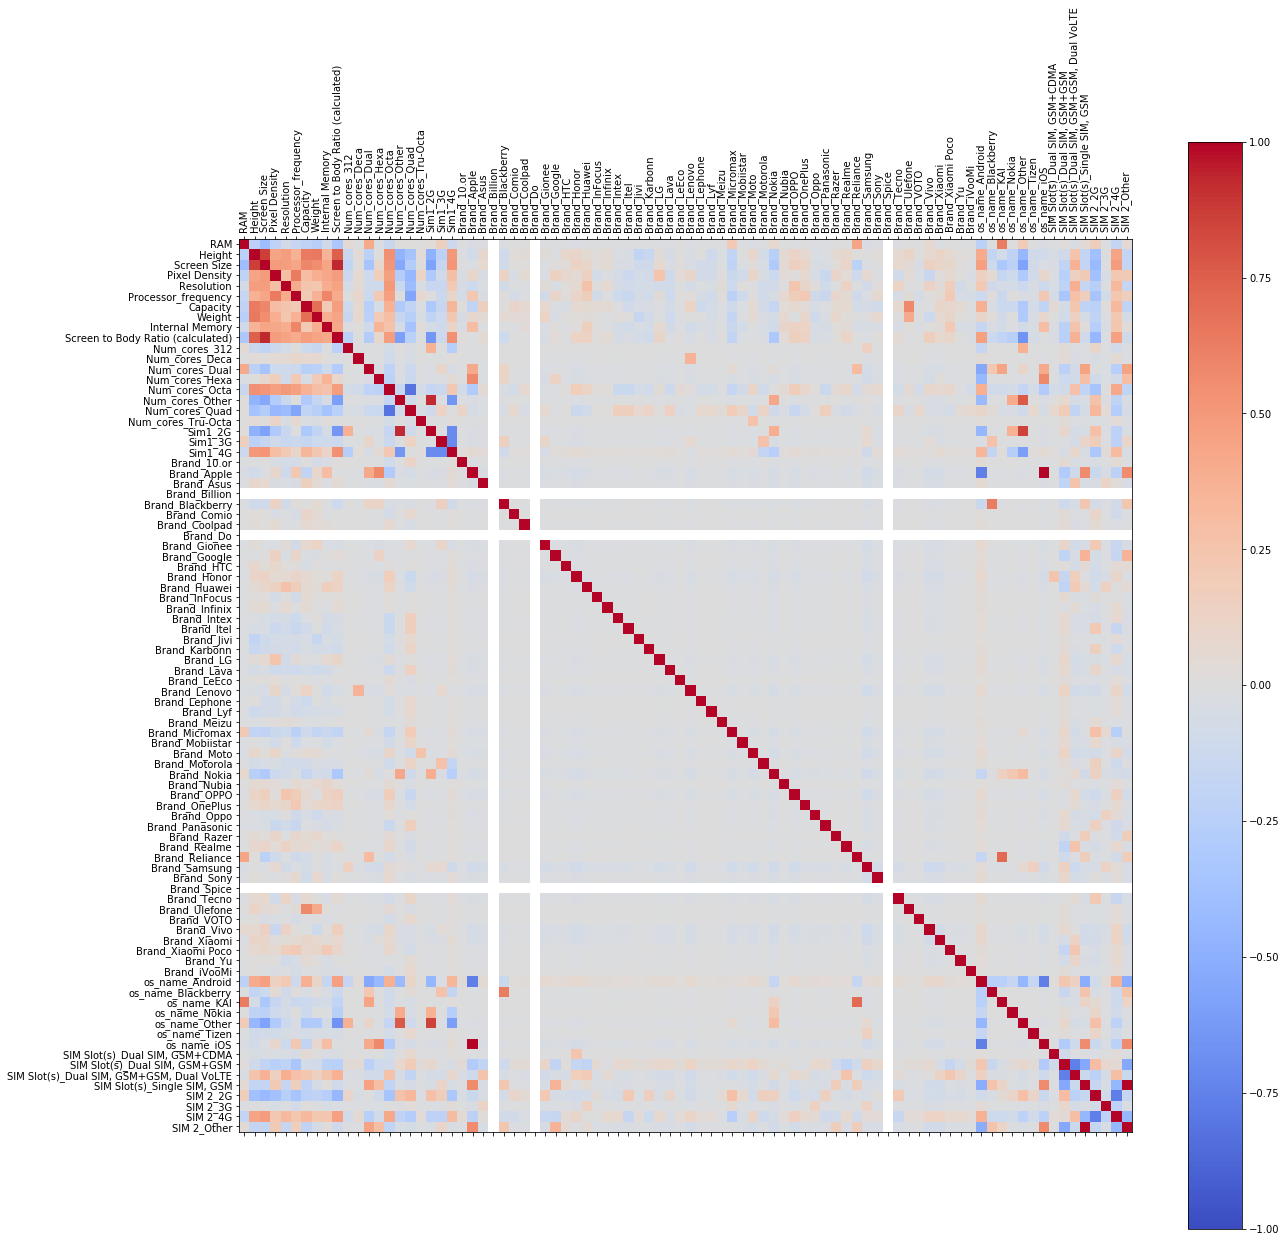

In [346]:
corr = X_train.corr()
fig = plt.figure()
fig.set_size_inches(20,20)
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(X_train.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(X_train.columns)
ax.set_yticklabels(X_train.columns)
plt.show()

# We can clearly see that Screen Size is positively correlated with Height and Screen to body Ratio
# There are other positively correlated variables too. Another good easy to understand example is 
# Brand_Apple and os_name_iOS.

# Look against the line of 'Brand_Apple' and compare it with all the top columns 
# It's obvious isn't it that an Apple iPhone / product user will have an iOS operating 
# system on his/her device. He/she cannot have an Android on his Apple iPhone. 
# This now introduces to you negative correlation. Notice how Brand_Apple and os_name_Andriod are
# negatively correlated (dark blue), which means Apple folks cannot have Android OS

### The Perceptron Model

#### Some Key Points which we need to understand with respect to building a model

##### 1. The idea is to get the Train accuracy close to Test accuracy so that the model follows a generalized behaviour and I can use it on any type of data that comes in, if at all I happen to deploy it.
##### 2. The model is more advanced than the primitive MP Neuron model built earlier on the same dataset, Perceptron is now able to take discrete as well as binary variables as input and output a binary value ( 0 or 1 )
##### 3. We use wiehgts and learning rate mechanisim in the Perceptron model to acheive model stabilty 
##### 4.
##### 5. I have even managed to get a better accuracy compared to my MP Neuron model on 71 % of the test data

### Key Factors & Observation for High Accuracy Score

#### 1. Dealing with correlation - 
#####  I removed one of the columns in the group of columns which were correlated, but I have tried to retain more discrete variable columns as much as I can. You can see that I removed Weight, Height, Screen to Body Ratio & Resolution in MP Neuron, but here I have removed Weight, Screen Size and Capacity just to prove the point on correlation. I have even removed the ones that are negatively correlated for perceptron model, If this is not done, then the accuracy cannot be improved.

#### 2. Accounting for the direction using Scatter plot - 
##### There is no need to worry about direction in Perceptron as weights and learning rate will account for it.

#### 3. Binary Columns -
##### If you notice I have removed correlation between binary categorical columns, the reason being I am confident that my wiehgts will take care of balancing the function of the model. In MP Neuron columns Apple_Brand and os_name_iOS both seemed to be important, where as in Perceptron I was able to remove one of the columns and yet maintain good accuracy. 

#### 4. Food for thought -
##### Num_cores_Other & Num_cores_Quad - Retained both columns to prove correlation theory, If I remove any one of the columns my 71% data gives **85% accuracy ( private score )**, If I retain my 71% data gives me **83.33 % accuracy ( private score ) **, the public score ( trian and test ) however is constant **85%**. You can try this out and also try removing one of the columns SIM 2_3G and SIM 2_4G and see what happens and let me know in the comments / through your Kernel !


In [347]:
X_train = np.array([
X_train['Weight'], 
#X_train['Height'],# Column removed due to correlation
X_train['Screen to Body Ratio (calculated)'],
X_train['Pixel Density'], 
X_train['Processor_frequency'], 
#X_train['Screen Size'],# Column removed due to correlation
X_train['RAM'], 
X_train['Resolution'], 
X_train['Internal Memory'], 
#X_train['Capacity'],# Column removed due to correlation
X_train['Brand_10.or'],
X_train['Brand_Apple'],
X_train['Brand_Asus'], 
#X_train['Brand_Billion'], # No Rows found, Removed to increase train accuracy due to scope of assignment
X_train['Brand_Blackberry'], 
X_train['Brand_Comio'], 
X_train['Brand_Coolpad'], 
#X_train['Brand_Do'], # No Rows found, Removed to increase train accuracy due to scope of assignment
X_train['Brand_Gionee'], 
X_train['Brand_Google'], 
X_train['Brand_HTC'], 
X_train['Brand_Honor'], 
X_train['Brand_Huawei'], 
X_train['Brand_InFocus'], 
X_train['Brand_Infinix'], 
X_train['Brand_Intex'], 
X_train['Brand_Itel'], 
X_train['Brand_Jivi'], 
X_train['Brand_Karbonn'], 
X_train['Brand_LG'], 
X_train['Brand_Lava'], 
X_train['Brand_LeEco'], 
X_train['Brand_Lenovo'], 
X_train['Brand_Lephone'], 
X_train['Brand_Lyf'], 
X_train['Brand_Meizu'], 
X_train['Brand_Micromax'], 
X_train['Brand_Mobiistar'], 
X_train['Brand_Moto'], 
X_train['Brand_Motorola'], 
X_train['Brand_Nokia'], 
X_train['Brand_Nubia'], 
X_train['Brand_OPPO'], 
X_train['Brand_OnePlus'],
X_train['Brand_Oppo'], 
X_train['Brand_Panasonic'], 
X_train['Brand_Razer'], 
X_train['Brand_Realme'], 
#X_train['Brand_Reliance'],# Removed due to correlation 
X_train['Brand_Samsung'], 
X_train['Brand_Sony'], 
#X_train['Brand_Spice'],# No Rows found, Removed to increase train accuracy due to scope of assignment 
X_train['Brand_Tecno'], 
X_train['Brand_Ulefone'], 
X_train['Brand_VOTO'], 
X_train['Brand_Vivo'], 
X_train['Brand_Xiaomi'], 
X_train['Brand_Xiaomi Poco'], 
X_train['Brand_Yu'], 
X_train['Brand_iVooMi'], 
X_train['SIM Slot(s)_Dual SIM, GSM+CDMA'], 
X_train['SIM Slot(s)_Dual SIM, GSM+GSM'], 
X_train['SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE'], 
# X_train['SIM Slot(s)_Single SIM, GSM'],# Removed due to correlation
X_train['Num_cores_312'], 
X_train['Num_cores_Deca'], 
X_train['Num_cores_Dual'], 
X_train['Num_cores_Hexa'], 
X_train['Num_cores_Octa'], 
X_train['Num_cores_Other'],# Food for thought column - Retained to prove correlation theory, If I remove this column my 71% data gives 
X_train['Num_cores_Quad'],# 85% accuracy compared to my current 83.33 % accuracy. I sacrificed my leaderboard rank for this !!
X_train['Num_cores_Tru-Octa'], 
#X_train['Sim1_2G'],# Column removed due to correlation
X_train['Sim1_3G'], 
#X_train['Sim1_4G'],# Column removed due to correlation
X_train['SIM 2_2G'], 
X_train['SIM 2_3G'], # Food for thought columns - What happens if I remove this and retain SIM 2_4G ?  
X_train['SIM 2_4G'], # Food for thought columns - What happens if I remove this and retain SIM 2_3G ?  
X_train['SIM 2_Other'], 
X_train['os_name_Android'], 
#X_train['os_name_Blackberry'], # Removed due to correlation  
#X_train['os_name_KAI'], # Removed due to correlation  
X_train['os_name_Nokia'], 
#X_train['os_name_Other'],# Removed due to correlation
X_train['os_name_Tizen'],  
#X_train['os_name_iOS'],# Removed due to correlation
    
]) 

X_train = X_train.T

In [348]:
X_test = np.array([
X_test['Weight'], 
#X_test['Height'],# Column removed due to correlation
X_test['Screen to Body Ratio (calculated)'], 
X_test['Pixel Density'], 
X_test['Processor_frequency'], 
#X_test['Screen Size'],# Column removed due to correlation 
X_test['RAM'], 
X_test['Resolution'], 
X_test['Internal Memory'], 
#X_test['Capacity'], # Column removed due to correlation
X_test['Brand_10.or'],
X_test['Brand_Apple'],
X_test['Brand_Asus'], 
#X_test['Brand_Billion'], # No Rows found, Removed to increase train accuracy due to scope of assignment
X_test['Brand_Blackberry'], 
X_test['Brand_Comio'], 
X_test['Brand_Coolpad'], 
#X_test['Brand_Do'], # No Rows found, Removed to increase train accuracy due to scope of assignment
X_test['Brand_Gionee'], 
X_test['Brand_Google'], 
X_test['Brand_HTC'], 
X_test['Brand_Honor'], 
X_test['Brand_Huawei'], 
X_test['Brand_InFocus'], 
X_test['Brand_Infinix'], 
X_test['Brand_Intex'], 
X_test['Brand_Itel'], 
X_test['Brand_Jivi'], 
X_test['Brand_Karbonn'], 
X_test['Brand_LG'], 
X_test['Brand_Lava'], 
X_test['Brand_LeEco'], 
X_test['Brand_Lenovo'], 
X_test['Brand_Lephone'], 
X_test['Brand_Lyf'], 
X_test['Brand_Meizu'], 
X_test['Brand_Micromax'], 
X_test['Brand_Mobiistar'], 
X_test['Brand_Moto'], 
X_test['Brand_Motorola'], 
X_test['Brand_Nokia'], 
X_test['Brand_Nubia'], 
X_test['Brand_OPPO'], 
X_test['Brand_OnePlus'],
X_test['Brand_Oppo'], 
X_test['Brand_Panasonic'], 
X_test['Brand_Razer'], 
X_test['Brand_Realme'], 
#X_test['Brand_Reliance'],# Removed due to correlation 
X_test['Brand_Samsung'], 
X_test['Brand_Sony'], 
#X_test['Brand_Spice'],# No Rows found, Removed to increase train accuracy due to scope of assignment 
X_test['Brand_Tecno'], 
X_test['Brand_Ulefone'], 
X_test['Brand_VOTO'], 
X_test['Brand_Vivo'], 
X_test['Brand_Xiaomi'], 
X_test['Brand_Xiaomi Poco'], 
X_test['Brand_Yu'], 
X_test['Brand_iVooMi'], 
X_test['SIM Slot(s)_Dual SIM, GSM+CDMA'], 
X_test['SIM Slot(s)_Dual SIM, GSM+GSM'], 
X_test['SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE'], 
# X_test['SIM Slot(s)_Single SIM, GSM'],# Removed due to correlation
X_test['Num_cores_312'], 
X_test['Num_cores_Deca'], 
X_test['Num_cores_Dual'], 
X_test['Num_cores_Hexa'], 
X_test['Num_cores_Octa'], 
X_test['Num_cores_Other'],# Food for thought column - Retained to prove correlation theory, If I remove this column my 71% data gives 
X_test['Num_cores_Quad'],# 85% accuracy compared to my current 83.33 % accuracy. I sacrificed my leaderboard rank for this !!
X_test['Num_cores_Tru-Octa'], 
#X_test['Sim1_2G'],# Column removed due to correlation
X_test['Sim1_3G'], 
#X_test['Sim1_4G'],# Column removed due to correlation
X_test['SIM 2_2G'], 
X_test['SIM 2_3G'], # Food for thought columns - What happens if I remove this and retain SIM 2_4G ?  
X_test['SIM 2_4G'], # Food for thought columns - What happens if I remove this and retain SIM 2_3G ?  
X_test['SIM 2_Other'], 
X_test['os_name_Android'], 
#X_test['os_name_Blackberry'], # Removed due to correlation  
# X_test['os_name_KAI'], # Removed due to correlation  
X_test['os_name_Nokia'], 
#X_test['os_name_Other'],# Removed due to correlation
X_test['os_name_Tizen'],  
#X_test['os_name_iOS'],# Removed due to correlation
    
]) 

X_test = X_test.T

### Min Max Scalar
#### We know through the describe() function that the scale ( range of values ) for all the features are not the same, some features like Capacity have a higher range of values where as some features like RAM have a smaller range. We have to sort this out before you pass your np.array to the model. We can " standardize " the scale using a Python MinMaxScalar function as shown below. Note that we are standardizing the input variables to fit into a discrete range of 0 to 1. Some of them get a question at this stage whether or not we have to Normalize the data, Normalization is not required ( however Normalization is an important aspect in feature engineering )

In [349]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
print(scaler.fit(X_train))
MinMaxScaler(copy=True, feature_range=(0, 1))

X_train = scaler.transform(X_train)

scaler = MinMaxScaler()
print(scaler.fit(X_test))
MinMaxScaler(copy=True, feature_range=(0, 1))

X_test = scaler.transform(X_test)

MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))


### X_train Standardized

In [350]:
X_train[0:1]

array([[0.45588235, 0.89103965, 0.60046189, 0.44444444, 0.00587084,
        0.7826087 , 0.125     , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 0.        ]])

In [351]:
class Perceptron:
    def __init__ (self):
        self.w = None
        self.b = None
 
    def model(self, x):
        return 1 if (np.dot(self.w, x) >= self.b) else 0
    
    def predict(self,X):
        Y = []
        for x in X:
            result=self.model(x)
            Y.append(result)
        return np.array(Y)
    
    def fit(self,X, Y, epochs = 1, lr = 1):
        #Weights = 0
        self.w = np.ones(X.shape[1]) #np.random.rand(73)
        self.b = 0 #random.randint(0,1)
        
        accuracy = {}
        max_accuracy = 0
        
        for i in range(epochs):
            for x,y in zip(X, Y):
                y_pred = self.model(x)
                if y==1 and y_pred ==0 :
                    self.w = self.w + lr * x
                    self.b = self.b - lr * 1
                #elif y==1 and y_pred == 1:
                    #self.w = self.w
                    #self.b = self.b
                #elif y==0 and y_pred == 0:
                    #self.w = self.w
                    #self.b = self.b
                elif y==0 and y_pred ==1:
                    self.w = self.w - lr * x
                    self.b = self.b + lr * 1
            accuracy[i] = accuracy_score(self.predict(X),Y)
            if (accuracy[i] > max_accuracy):
                max_accuracy = accuracy[i]
                chkptw = self.w
                chkptb = self.b
            #    self.var = self.var - 1
            #elif (accuracy[i] < max_accuracy):
            #    self.var = self.var + 1
                
        self.w = chkptw
        self.b = chkptb
        
        print(max_accuracy)
        #print(self.var)
        print(self.w)
        plt.plot(accuracy.values())
        plt.ylim([0,1])
        plt.show()

In [352]:
perceptron = Perceptron()

### Epochs and Learning Rate
#### Best practise is to adjust Epochs and Learning rate in steps to improve accuracy. I used a high epoch value and a lower learning rate to stablize the model. You can try with other epoch values and observe the curve.

0.8563049853372434
[-0.10588235 -0.09256947 -0.00979215  0.05516667 -0.12363992 -0.03782609
  0.35359375  0.82        1.23        1.          0.84        1.02
  0.85        0.95        1.          0.9         0.97        1.07
  0.83        0.96        0.82        0.99        0.83        0.85
  0.9         0.98        1.01        0.93        0.91        0.91
  1.07        0.94        0.96        0.97        1.11        0.94
  0.81        1.11        1.01        0.97        0.96        0.81
  1.01        0.99        0.92        1.01        1.04        0.87
  1.          0.95        1.          0.91        0.91        1.
  0.11        0.1         1.          0.48        0.6         0.62
  0.61        0.84        0.6         1.         -0.06        0.4
  0.39        0.42        0.54        0.27        1.          0.13      ]


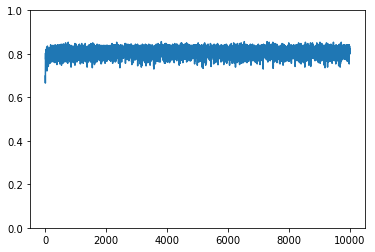

In [353]:
perceptron.fit(X_train,Y_train,10000,.01)

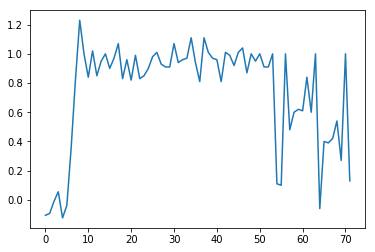

In [354]:
plt.plot(perceptron.w)
plt.show()

In [355]:
Y_pred_train = perceptron.predict(X_train)

In [356]:
Y_pred_test = perceptron.predict(X_test)
Y_pred_test = list(Y_pred_test)
print(Y_pred_test)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1]


In [357]:
submission = pd.DataFrame({'PhoneId':test_new['PhoneId'], 'Class':Y_pred_test})
submission = submission[['PhoneId', 'Class']]
submission.head()

,PhoneId,Class
0,3,1
1,11,1
2,13,1
3,16,1
4,19,1


In [358]:
submission.to_csv("submission.csv", index=False)

### Acheivements

##### 1. The above logic has worked best for me resulting in a train accuracy of **85.63%** and a test accuracy of **85.74 %** on **29%** of the data followed by **83.33 %** on **71% **of the data.
##### 2. I feel the model is consistent and will not vary over a varience of **5%** which is my cut off for accuracy on any given dataset which is able to fit into the model
##### 3. Feature addition & handling can be re-engineerd, hence the model is scalable with few tweaks
##### 4. Kaggle rank **42** out of **1080** ( **Top 4%** )
##### 5. Possible & Proven improvement of Kaggle rank to **14** out of **1080** ( **Top 2%** ) with code tweaks as explained above and taking full advantage of eliminating correlating variables.

### Key Mentions & References

##### 1. https://www.91mobiles.com for providing padhai.onefourthlabs.in the dataset to analyze and work upon
##### 2. The entire team of https://padhai.onefourthlabs.in for their supreme training efforts, dedication, data cleansing and quality time in helping the newbies and pros scale higher in their pursuit of becoming a better data scientist  
##### 3. https://www.stackoverflow.com - for most of the doubts, errors & shortcuts in python 
##### 4. My Ex Manager & Mentor for life, Arulvel Kumar - https://au.linkedin.com/in/arulvel-kumar who has been a great motivation and driving force of my data science career. 